## Mini Kaggle Competition, The Bridge
Team: Eddy, Olga, Frank

Creating files structure

Final accuracy: 83,54%

In [1]:
import keras
import numpy as np
import os, shutil
import pandas as pd

#TRansfer Learning
from keras.applications import VGG16
#modeling
from keras.models import Sequential
from keras.layers import Flatten
from keras import models
from keras import layers
from keras import optimizers

In [2]:
#installing libraries
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install py7zr

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=43b31da27a7bf5c2d2e367840c4b3fdb9611d56f962eafdb6f58fda649866e4e
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 13.7MB 234kB/s 


In [3]:
#Uploading kaggle.json
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
#creating path
!mkdir $HOME/.kaggle
!mv kaggle.json $HOME/.kaggle/kaggle.json
!chmod 600 $HOME/.kaggle/kaggle.json

In [5]:
#downloading data from Kaggle
!kaggle competitions download -c cifar-10 --force

 97% 697M/715M [00:16<00:00, 22.0MB/s]
100% 715M/715M [00:16<00:00, 46.3MB/s]


In [6]:
#Unzip files
!unzip -qq /content/cifar-10.zip -d /content/cifar10
print("root -->", os.listdir())
print("cifar10 --> ", os.listdir("cifar10"))

root --> ['.config', 'cifar10', 'cifar-10.zip', 'sample_data']
cifar10 -->  ['test.7z', 'train.7z', 'trainLabels.csv', 'sampleSubmission.csv']


In [7]:
# The path to the directory where the original zip files are
zip_data = 'cifar10/train.7z'
#zip_test = 'cifar10/test.7z'

#train
from py7zr import SevenZipFile
with SevenZipFile(zip_data, 'r') as myzip:
  print("data len --> {}".format(len(myzip.getnames())-1))
  print("train names --> {}".format(myzip.getnames()[0:10]))

data len --> 50000
train names --> ['train/1.png', 'train/10.png', 'train/100.png', 'train/1000.png', 'train/10000.png', 'train/10001.png', 'train/10002.png', 'train/10003.png', 'train/10004.png', 'train/10005.png']


In [8]:
#Extract train Data Set
with SevenZipFile(zip_data, 'r') as myzip:
  myzip.extractall('origin_data')
print("images count", len(os.listdir('origin_data/train')))

images count 50000


# Creating Files Structure

In [9]:
#Unlabelled data
unlab_data = 'origin_data/train'

# The directory where we will store our labeled dataset
base_dir = '/content/data_to_process'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training and test splits.
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)


#Create classes folders
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dir = [train_dir, test_dir]
for d in dir:
  for l in labels:
    if not os.path.exists(os.path.join(d, l)):
      os.mkdir(os.path.join(d, l))

print('label_data -->', os.listdir('data_to_process'))
print('clases -->', os.listdir('data_to_process/test'))

label_data --> ['train', 'test']
clases --> ['deer', 'dog', 'truck', 'automobile', 'horse', 'frog', 'ship', 'cat', 'bird', 'airplane']


In [10]:
#Leer labels csv
labels_df = pd.read_csv('cifar10/trainLabels.csv')
print(labels_df.shape)
labels_df.head()

(50000, 2)


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [11]:
#copy from origin data to train class labeled folders
for id, label in zip(labels_df['id'], labels_df['label']):
  fname = '{}.png'.format(id)
  src = os.path.join(unlab_data, fname) #source 
  
  file_dst = os.path.join(train_dir, label) 
  fname_final = label + '_{}'.format(fname)
  dst = os.path.join(file_dst, fname_final) 
  
  shutil.copyfile(src, dst) #move

In [12]:
#Copy 500 from each class to test folder
for lab in labels_df.label.unique():
  flist = os.listdir(os.path.join(train_dir, lab)) #list of img in labels
  for fname in flist[0:500]:
    src = os.path.join(train_dir, lab, fname) #source
    file_dst = os.path.join(test_dir, lab)
    dst = os.path.join(file_dst, fname) #dst
    shutil.move(src, dst) #move
  continue

In [13]:
print('***train***')
for x in labels:
    print(x, len(os.listdir(os.path.join(train_dir, x))))
print('-----------------------------')
print('***test***')
for x in labels:
    print(x, len(os.listdir(os.path.join(test_dir, x))))

***train***
airplane 4500
automobile 4500
bird 4500
cat 4500
deer 4500
dog 4500
frog 4500
horse 4500
ship 4500
truck 4500
-----------------------------
***test***
airplane 500
automobile 500
bird 500
cat 500
deer 500
dog 500
frog 500
horse 500
ship 500
truck 500


# Preprocesing

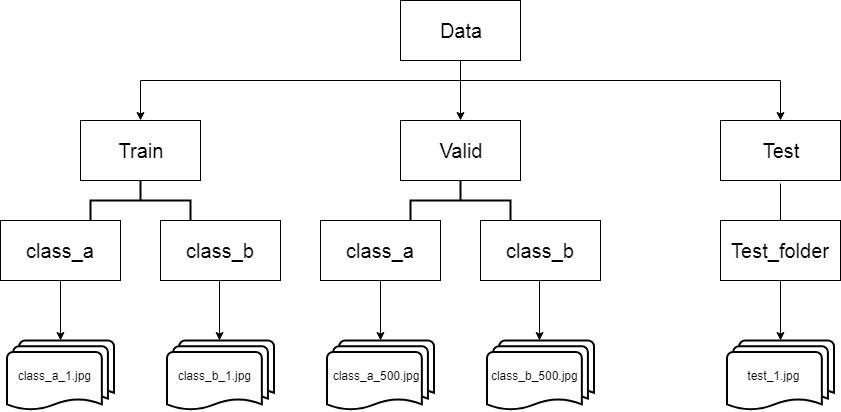

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=2, 
                                   horizontal_flip=True,
                                   zoom_range=.1)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        batch_size = 32,
        target_size = (32, 32),
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (32, 32),
        class_mode='categorical')

Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [15]:
for x in train_generator:
  print(x[0].shape)
  break

(32, 32, 32, 3)


# Training

In [16]:
#Using VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3),)

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [18]:
#Creating Model. Using Transfer Learning.
model = models.Sequential()

model.add(conv_base)
model.add(Flatten())

model.add(layers.Dense(130, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dense(190, activation='relu'))
model.add(layers.Dense(220, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [19]:
# Compiling
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [20]:
# Fit
history = model.fit(train_generator,
                    epochs= 10,    
                    validation_data=test_generator)

Epoch 1/10
1407/1407 [==============================] - 43s 31ms/step - loss: 1.4075 - acc: 0.5127 - val_loss: 0.8871 - val_acc: 0.7004
Epoch 2/10
1407/1407 [==============================] - 43s 31ms/step - loss: 0.8921 - acc: 0.7120 - val_loss: 0.6964 - val_acc: 0.7666
Epoch 3/10
1407/1407 [==============================] - 42s 30ms/step - loss: 0.7252 - acc: 0.7694 - val_loss: 0.6146 - val_acc: 0.7960
Epoch 4/10
1407/1407 [==============================] - 42s 30ms/step - loss: 0.6260 - acc: 0.8023 - val_loss: 0.5791 - val_acc: 0.8120
Epoch 5/10
1407/1407 [==============================] - 42s 30ms/step - loss: 0.5538 - acc: 0.8237 - val_loss: 0.5640 - val_acc: 0.8176
Epoch 6/10
1407/1407 [==============================] - 43s 30ms/step - loss: 0.4975 - acc: 0.8422 - val_loss: 0.5642 - val_acc: 0.8216
Epoch 7/10
1407/1407 [==============================] - 42s 30ms/step - loss: 0.4541 - acc: 0.8564 - val_loss: 0.5195 - val_acc: 0.8302
Epoch 8/10
1407/1407 [==========================